## read in the data

In [2]:
import os
print(os.getcwd())

# data_dir = os.getcwd()+"/paper/"
# print(data_dir)

os.chdir("/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo")

from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from IPython.display import HTML
from tqdm import tqdm_notebook

data, scaler = load_data() # helper function to load in a dictionary containing our dataset.

/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo


In [3]:
data['X'].head()

,Married,Single,Age_lt_25,Age_in_25_to_40,Age_in_40_to_59,...,MostRecentBillAmount,MostRecentPaymentAmount,TotalOverdueCounts,TotalMonthsOverdue,HistoryOfOverduePayments
0,1,0,1,0,0,...,120,0,1,4,1
1,0,1,0,1,0,...,80,0,2,4,1
2,0,1,0,1,0,...,890,50,0,0,0
3,1,0,0,1,0,...,1430,60,0,0,0
4,1,0,0,0,1,...,260,60,0,0,0


In [18]:
X = data['X']
y = data['y']

X['age1'] = X['Age_lt_25'].apply(lambda x: 1 if x==1 else 0)
X['age2'] = X['Age_in_25_to_40'].apply(lambda x: 2 if x==1 else 0)
X['age3'] = X['Age_in_40_to_59'].apply(lambda x: 3 if x==1 else 0)
X['age4'] = X['Age_geq_60'].apply(lambda x: 4 if x==1 else 0)
X['Age'] = X['age1'] + X['age2'] + X['age3'] + X['age4']

## the only thing left is 'Age'
data_df = (X.drop(['age1', 'age2', 'age3', 'age4'], axis=1)
            .drop(['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59','Age_geq_60'], axis=1)
            .copy(deep=True))

print(data_df.dtypes)
print()

X = data_df.drop(['Age'], axis=1)

print(X.dtypes)
print(len(X.dtypes))

Married                                  int64
Single                                   int64
EducationLevel                           int64
MaxBillAmountOverLast6Months             int64
MaxPaymentAmountOverLast6Months          int64
MonthsWithZeroBalanceOverLast6Months     int64
MonthsWithLowSpendingOverLast6Months     int64
MonthsWithHighSpendingOverLast6Months    int64
MostRecentBillAmount                     int64
MostRecentPaymentAmount                  int64
TotalOverdueCounts                       int64
TotalMonthsOverdue                       int64
HistoryOfOverduePayments                 int64
Age                                      int64
dtype: object

Married                                  int64
Single                                   int64
EducationLevel                           int64
MaxBillAmountOverLast6Months             int64
MaxPaymentAmountOverLast6Months          int64
MonthsWithZeroBalanceOverLast6Months     int64
MonthsWithLowSpendingOverLast6Months     int6

## train classifier

In [23]:
## train
clf = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X, y)
)

## create actionset

In [24]:
# action set
default_bounds = (1.0, 99.0, 'percentile')
custom_bounds = None
immutable_variables = []

# action_set = ActionSet(X=X_clf)

# if settings['data_name'] == 'credit':
#     ## set features in our input data that are immutable: 
#     ##     i.e. individuals will not be asked to change any of these 
#     ##          variables when the optimizer seeks recourse.
immutable_names = ['Single', 'Married']
immutable_names += list(filter(lambda x: 'Overdue' in x, data['variable_names']))

#     data['immutable_variable_names'] = [n for n in immutable_names if n in data['variable_names']]

#     ## set the default and custom bounds we wish to search over.
default_bounds = (0.1, 99.9, 'percentile')
custom_bounds = {'Married': (0, 100, 'p')}

action_set = ActionSet(X = X, axis=1, custom_bounds = custom_bounds, default_bounds = default_bounds)
for var in immutable_names:
    action_set[var].mutable = False

#     ## set other custom behaviors in each of the data types.
action_set['EducationLevel'].step_direction = 1
payment_fields = list(filter(lambda x: 'Amount' in x, data['variable_names']))
action_set[payment_fields].step_type = 'absolute'
action_set[payment_fields].step_size = 50

for p in payment_fields:
    action_set[p].update_grid()

## run audit

In [25]:
# median score
np.median(clf.predict_proba(X)[:, 1])

0.8505384252380148

In [26]:
# cache classifier
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
action_set.align(coefficients=coefficients)

# audit
p = np.median(clf.predict_proba(X)[:, 1]) ## for now we'll set this to the median score, but we could set this to any threshold we want.
auditor = RecourseAuditor(
    action_set,
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
audit_results = auditor.audit(X = X)

## visualize

In [28]:
data_df = pd.concat([data_df['Age'], y], axis=1, join='inner')

data_df.head()

,Age,NoDefaultNextMonth
0,1,0.0
1,2,0.0
2,2,1.0
3,2,1.0
4,3,1.0


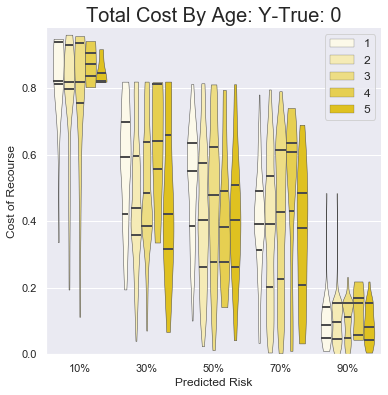

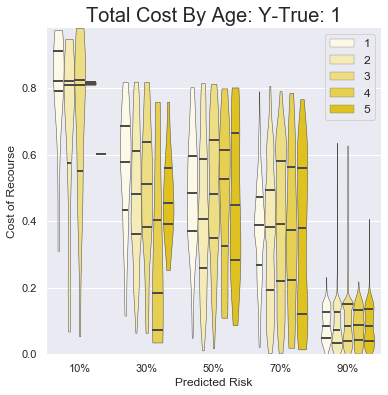

In [106]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
matching_df = pd.concat([
    data_df,
    audit_results[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()

####### Matching 2: Control for Y=+/- 1
matching_df['y_pred_bin'] = pd.cut(
    matching_df['y_pred'],
    bins=np.arange(0, 1.1, .2)
)

# print(matching_df)

bins = matching_df['y_pred_bin'].unique()

# print(matching_df.groupby(['y_pred_bin']).count())

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [0, 1]:
    plt.figure(figsize=(6, 6))
    ax = sns.violinplot(
        x='y_pred_bin',  y='cost', hue='Age',
        data=matching_df.loc[lambda df: df['NoDefaultNextMonth'] == y_true].sort_values('Age'),
        linewidth = 0.5, cut=0, background='white',
        scale='width',
        color='gold',
        inner='quartile'
    )
    ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    plt.title('Total Cost By Age: Y-True: %d' % y_true, fontsize=20)
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

#     if y_true == -1:
#         plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
#     else:
    plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1, 1))
    
    
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')
        
    plt.show() 

## try to fix the legend

/opt/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


[<matplotlib.patches.Rectangle object at 0x1a201168d0>, <matplotlib.patches.Rectangle object at 0x1a1d6d1410>, <matplotlib.patches.Rectangle object at 0x1a1f355590>, <matplotlib.patches.Rectangle object at 0x1a1f5a1e50>, <matplotlib.patches.Rectangle object at 0x1a1deca850>]
['1', '2', '3', '4', '5']


<Figure size 1080x1152 with 0 Axes>

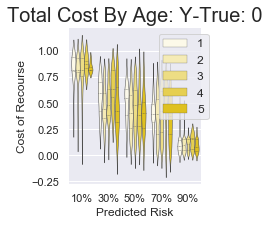

/opt/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


[<matplotlib.patches.Rectangle object at 0x1a1e4a47d0>, <matplotlib.patches.Rectangle object at 0x1a1e4fb3d0>, <matplotlib.patches.Rectangle object at 0x1a1d6e78d0>, <matplotlib.patches.Rectangle object at 0x1a1e4a4f50>, <matplotlib.patches.Rectangle object at 0x1a1d6e7190>]
['1', '2', '3', '4', '5']


<Figure size 1080x1152 with 0 Axes>

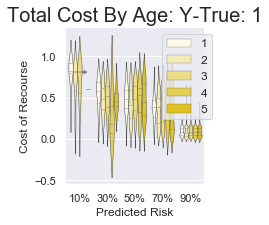

In [97]:
# scores = pd.Series(clf.predict_proba(X)[:, 1])
# matching_df = pd.concat([
#     data_df,
#     audit_results[['cost']],
#     scores.to_frame('y_pred')
#     ], axis=1).replace(np.inf, np.nan).dropna()

# ####### Matching 2: Control for Y=+/- 1
# matching_df['y_pred_bin'] = pd.cut(
#     matching_df['y_pred'],
#     bins=np.arange(0, 1.1, .2)
# )

# # print(matching_df)

# bins = matching_df['y_pred_bin'].unique()

# # print(matching_df.groupby(['y_pred_bin']).count())

# max_cost = matching_df['cost'].max()
# plt.rc("font", size=20)
# for y_true in [0, 1]:
    
#     plt.figure(figsize=(15, 16))
    
#     sns.set(rc={'figure.figsize':(20, 20)})
    
#     ax = sns.FacetGrid(matching_df.loc[lambda df: df['NoDefaultNextMonth'] == y_true].sort_values('Age'))
#     ax = ax.map(sns.violinplot, 'y_pred_bin',  'cost', 'Age',
#         data=matching_df.loc[lambda df: df['NoDefaultNextMonth'] == y_true].sort_values('Age'),
#         linewidth = 0.5, background='white',
#         scale='width',
#         color='gold',
#         inner='quartile', 
# #                 split=True, 
# #                 saturation=1
#                ).despine(left=True)
    
#     handles, labels = ax.fig.get_axes()[0].get_legend_handles_labels()
#     print(handles)
#     print(labels)
#     ax.fig.get_axes()[0].legend([handles[0], handles[1], handles[2], handles[3], handles[4], ], ['<25', '25-40', '40-59','>60'], loc='upper left')

    
# #     ax = sns.violinplot(
# #         x='y_pred_bin',  y='cost', hue='Age',
# #         data=matching_df.loc[lambda df: df['NoDefaultNextMonth'] == y_true].sort_values('Age'),
# #         linewidth = 0.5, cut=0, background='white',
# #         scale='width',
# #         color='gold',
# #         inner='quartile'
# #     )
    
# #     ax.get_axes()[0].set_xlabel("Lunch")
# #     g.fig.get_axes()[1].set_xlabel("Dinner")
    
#     ax.set_xticklabels(["10%", "30%", "50%", "70%", "90%"])
    
# #     ax.set_axis_labels('<25', '25-40', '40-59','>60')

# #     ax.spines['right'].set_visible(False)
# #     ax.spines['top'].set_visible(False)

# #     ax.set_ylim((0, max_cost))
#     plt.title('Total Cost By Age: Y-True: %d' % y_true, fontsize=20)
#     plt.ylabel('Cost of Recourse')
#     plt.xlabel('Predicted Risk' )

#     plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
    
# #     for l in ax.lines:
# #         l.set_linewidth(2.)
# #         l.set_linestyle('-')
# #         l.set_solid_capstyle('butt')
        
#     plt.show() 

In [ ]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
matching_df = pd.concat([
    data_df,
    audit_results[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()


####### Matching 2: Control for Y=+/- 1
matching_df['y_pred_bin'] = pd.cut(
    matching_df['y_pred'],
    bins=np.arange(0, 1.1, .2)
)


bins = matching_df['y_pred_bin'].unique()

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [-1, 1]:
    plt.figure(figsize=(4, 4))
    ax = sns.violinplot(
        x='y_pred_bin',  y='cost', hue='Age',
        data=matching_df.loc[lambda df: df['Age'] == y_true].sort_values('Age'),
        linewidth = 0.5, cut=0, background='white',
        scale = 'width', color="gold",  inner = 'quartile'
    )
    ax.set_xticklabels(["10%", "30%", "50%", "70%", '90%'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    plt.title('Total Cost By Gender: Y-True: %d' % y_true, fontsize=20)
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

    if y_true == -1:
        plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
    else:
        plt.legend(fontsize=12., loc='lower left')#, bbox_to_anchor=(1.1, 1))
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')

    plt.show() 